# Walmart Hours and Crime


## Background
A rule-of-thumb I used to frequently use was to determine the quality of a neighborhood based on the Walmart's nearby. If the Walmart is open 24 hours, you are good. If it's not, then be careful, my sweet reader. In 2017, some friends and I went to Tennessee to see a solar eclipse and all the hotels were booked. My instinctual thought was to go to the nearest Walmart that is open 24 hours and just crash in the car. Upon arriving, we saw a bunch of people doing the same, so we felt pretty good about it. That was the first time I used that heuristic outside my home state, and it worked. I was sure this rule was damn natural law after that. Fast-forward to 2019. I graduated from school, moved to Boston, and looking for an apartment. First thing I did: searched on Google for Walmart's. The results frightened me. Something I didn't believe possible happened: there weren't any Walmart's. Being that Boston is a pretty safe city, I take it that walmart not being in an area at all is a good indicator of a good neighborhood too. Which totally sounds right.


## Hypothesis
I believe there is a strong relationship between crime and the operating hours of Walmart. I expect that places with a walmart will have higher crime rates than places without. But if you do have a walmart in your area, the longer the store is open, the lower the crime rate. To test this, I need two datasets.

1. Walmart store hours and locations
2. Crime data

I tried looking for crime data broken down by zip code, but couldn't find anything that detailed. I found some data on [wikipedia](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_violent_crime_rate) that gives crime rates at the state level. So although, I would rather do the zip code analysis, I will have to settle for a state level one. If anyone knows where I can get crime data by zip code, please let me know.


## The Data

I looked up how many Walmart stores there are in the US and scrapped the data I need for all 3568 stores. The code for that and the scrapper I used for the table on Wikipedia can be found [here](https://github.com/jiduque/effective-octo-giggle/tree/main/walmart/). I also wanted to normalize the number of walmarts in a state by the number of people in the state, so I got some 2018 population data from [here](https://www.icip.iastate.edu/tables/population/states-estimates).

In [53]:
from json import load
import pandas as pd

from wiki_scrapper import load_stats

states = ['ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'HAWAII', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING', 'DISTRICT OF COLUMBIA', 'PUERTO RICO']

abv = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC', 'PR']

abbreviation_map = dict( (key, val) for key, val in zip(states, abv) )

crime_data = load_stats()
crime_data = dict( (abbreviation_map[key.upper()], val) for key, val in crime_data.items())


with open("state_population_2018.json") as f:
    data = load(f)
    population_data = dict( (abbreviation_map[state.upper()], val)  for state, val in data.items() )

walmart_data = pd.read_csv("walmart_data.csv")
walmart_data

,postalCode,address,city,state,startHr,endHr,storeNumber
0,72756,2110 W Walnut St,Rogers,AR,00:00,24:00,1
1,72601,161 N Walmart Dr,Harrison,AR,00:00,24:00,2
2,30529,30983 Highway 441 S,Commerce,GA,00:00,24:00,3
3,72761,2901 Highway 412 E,Siloam Springs,AR,00:00,24:00,4
4,72032,1155 Hwy 65 North,Conway,AR,00:00,24:00,5
...,...,...,...,...,...,...,...
3561,25526,167 Progress Way,Hurricane,WV,00:00,24:00,4277
3562,25015,1001 Warrior Way,Quincy,WV,00:00,24:00,4278
3563,76065,400 N Highway 67,Midlothian,TX,00:00,24:00,4279
3564,76645,401 Coke Ave,Hillsboro,TX,00:00,24:00,211


**Note**: Four stores were missing from the original dataset. The missing store numbers were: 211, 717, 2201, and 2670. Two of these I added manually, and the other two are closed. Store 2201 was actually the one where the El Paso shooting happened.

## Plots

In [54]:
import plotly.graph_objects as go 


walmart_data["isReal"] = (walmart_data["startHr"] == "00:00") & (walmart_data["endHr"] == "24:00")


df = walmart_data.groupby(["state"])["isReal"].mean().reset_index()


fig = go.Figure(data=go.Choropleth(
    locations=df['state'],
    z = df['isReal'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Percentage"
))

fig.update_layout(
    title_text = '24-hour Walmarts by State',
    geo_scope='usa'
)

fig.show()

In [55]:
df = walmart_data.groupby(["state"])["storeNumber"].count().reset_index()


fig = go.Figure(data=go.Choropleth(
    locations=df['state'],
    z = df['storeNumber'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Number of Stores"
))

fig.update_layout(
    title_text = 'Number of Walmarts by State',
    geo_scope='usa'
)

fig.show()

In [56]:
df = pd.DataFrame( [{"state": key.upper(), "crime_rate": val} for key, val in crime_data.items()] )

fig = go.Figure(data=go.Choropleth(
    locations=df['state'],
    z = df['crime_rate'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Crime Rate"
))

fig.update_layout(
    title_text = '2018 Crime Rate by State',
    geo_scope='usa'
)

fig.show()

Already, this is looking like I was wrong.

In [57]:
import numpy as np


def hours_diff(end_times, start_times):
    output = []

    for end_time, start_time in zip(end_times, start_times):
        end_hr = int(end_time.split(":")[0])
        start_hr = int(start_time.split(":")[0])

        val = end_hr - start_hr

        if end_hr < 12:
            val += 24
        output.append(val)

    return output


def merge_data(wm_data, pop_data, cr_data):
    walmart_states = set(wm_data["state"])
    number_of_stores = wm_data.groupby(["state"])["storeNumber"].count().reset_index()

    output = []
    for state in pop_data.keys():
        n_stores = number_of_stores[number_of_stores["state"] == state]["storeNumber"].iloc[-1]
        n_people = pop_data[state]
        people_per_store = n_people / n_stores
        mean_hrs = 0
        if state in walmart_states:
            tmp = wm_data[wm_data["state"] == state][["startHr", "endHr"]]
            mean_hrs = np.mean(hours_diff(tmp["endHr"], tmp["startHr"]))
        output.append({
            "state": state,
            "people_per_store": people_per_store,
            "mean_hrs": mean_hrs,
            "crime_rate": cr_data[state]
        })

    return pd.DataFrame(output)

summarized_data = merge_data(walmart_data, population_data, crime_data)
summarized_data

## Conclusion

At a national level, Walmart hours have nothing to do with how safe a state is. So, don't listen to me and my intuition (although, I do still feel strongly a relationship exists at the zip code level). The results are shown below.

In [77]:
from statsmodels.api import OLS

def normalize(col_data):
    mu = col_data.mean()
    sigma = col_data.std()
    return (col_data - mu) / sigma


normalized_data = summarized_data.copy()
normalized_data["crime_rate"] = normalize(normalized_data["crime_rate"])
normalized_data["people_per_store"] = normalize(normalized_data["people_per_store"])
normalized_data["mean_hrs"] = normalize(normalized_data["mean_hrs"])

lm = OLS(normalized_data["crime_rate"], normalized_data[["people_per_store", "mean_hrs"]]).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:             crime_rate   R-squared (uncentered):                   0.174
Model:                            OLS   Adj. R-squared (uncentered):              0.140
Method:                 Least Squares   F-statistic:                              5.153
Date:                Wed, 12 Oct 2022   Prob (F-statistic):                     0.00931
Time:                        00:14:50   Log-Likelihood:                         -66.993
No. Observations:                  51   AIC:                                      138.0
Df Residuals:                      49   BIC:                                      141.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

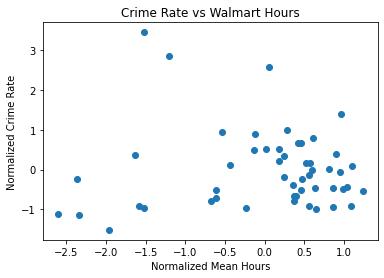

In [78]:
import matplotlib.pyplot as plt

plt.scatter(normalized_data["mean_hrs"], normalized_data["crime_rate"])
plt.xlabel("Normalized Mean Hours")
plt.ylabel("Normalized Crime Rate")
plt.title("Crime Rate vs Walmart Hours")
plt.show()

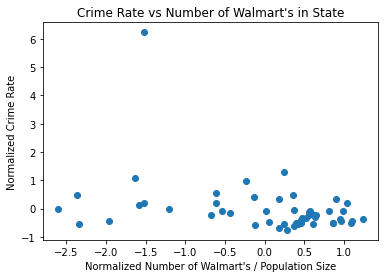

In [79]:
plt.scatter(normalized_data["mean_hrs"], normalized_data["people_per_store"])
plt.xlabel("Normalized Number of Walmart's / Population Size")
plt.ylabel("Normalized Crime Rate")
plt.title("Crime Rate vs Number of Walmart's in State")
plt.show()